# Тeматическое моделирование

In [1]:
! pip install spacy -q
! python -m spacy download ru_core_news_sm -q
! pip install pyLDAvis -q

2023-07-01 04:34:05.505617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 04:34:10.018257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 18.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Подключаем библиотеки.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from gensim.models import LsiModel
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
import json
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory data analysis

Укажем путь к файлу.

In [3]:
!gdown 1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj
!gdown 1Z53Jdj-E3E2OfnJhwrqLuvcQrEZ9aNd5

Downloading...
From: https://drive.google.com/uc?id=1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj
To: /content/clean_posts.csv
100% 3.79M/3.79M [00:00<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z53Jdj-E3E2OfnJhwrqLuvcQrEZ9aNd5
To: /content/raw_posts.csv
100% 23.9M/23.9M [00:00<00:00, 74.5MB/s]


Загрузим данные в dataframe.

In [4]:
df = pd.read_csv('/content/clean_posts.csv')
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


In [5]:
df2 = pd.read_csv('/content/raw_posts.csv')
df2.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0.0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1.0,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1.0,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0.0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9.0,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


Посмотрим на дубли.

In [6]:
df.duplicated().sum(),df2.duplicated().sum()

(0, 4266)

In [7]:
df3 = pd.concat([df, df2])

Удалим дубликаты.

In [8]:
df = df3.drop_duplicates()

Посмотрим на размер выборки.

In [9]:
df.shape

(16148, 13)

Посчитаем колличество уникальных имен ссылок на аккаунты.

In [10]:
df.account_link.nunique()

1948

In [11]:
df = df.fillna(0)

1092 ссылки на аккаунты.

**Посмотрим на числянные признаки.**

In [12]:
df.describe()

,experience,posts_cnt,comments_cnt,repost_cnt
count,16148.000000,16148.000000,16148.00000,16148.000000
mean,6.260156,22.683428,5.53375,5.788828
std,58.091625,68.225547,44.17043,45.247801
min,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000
75%,5.000000,2.000000,1.00000,0.000000
max,1806.000000,376.000000,967.00000,979.000000


# Experience - опыт.

Очевидно, что есть выбросы по опыту. Ну никак больше 100 лет у нас не может быть в этих данных. Тем более 800 лет. Данный признак мы не оцениваем. Посмотрим сколько таких строк.

In [13]:
len(df[df.experience>100])

70

Посмотрим, есть ли посты у людей сопытом более 100 лет.

In [14]:
df[df.experience>100].posts_cnt.value_counts(dropna=False)

posts_cnt
0.0    38
8.0    10
4.0     8
2.0     8
7.0     6
Name: count, dtype: int64

Посты есть, не будем их удалять. Но посмотри на распределение без этих значений.

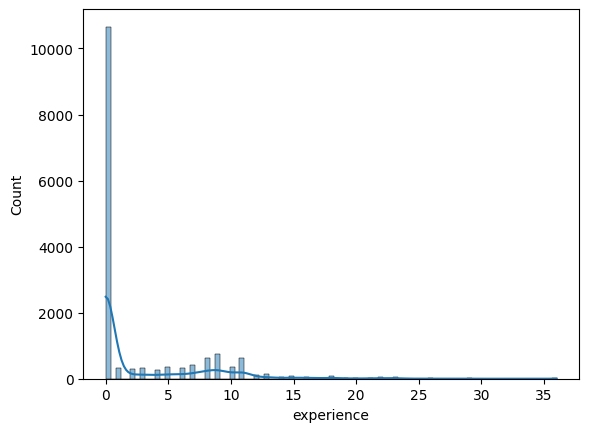

In [15]:
sns.histplot(df.query('experience<100')['experience'], kde=True)
plt.show()

Как видно, большинство пользователей с опытом до 10 лет. Около 10 лет - наиболее популярный опыт работы у собранных специалистов. А далее видим резкий спад. Людей с опытом более 15 лет практически нет. Что логично IT достаточно молодая отрасль.

# posts_cnt - кол-во постов.

Посмотрим на распредление по кол-ву постов.

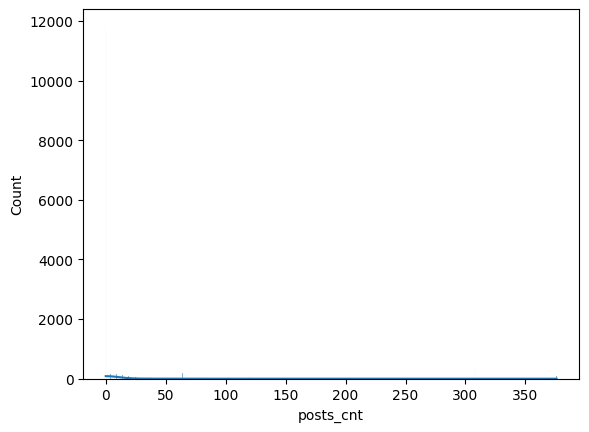

In [16]:
sns.histplot(df.posts_cnt, kde=True)
plt.show()

Большинство профилей не имеют постов. Есть единичные пики у 200, 250 и 370. Посмотрим, сколько у нас таких пользователей.

In [17]:
df[df.posts_cnt>170]['name'].nunique()

4

4 пользователя с таким кол-вом постов.Интересно узнать их должности.

In [18]:
df[df.posts_cnt>170]['title'].unique()

array(['Senior Data Scientist / NLP Engineer',
       'Senior Technical Recruiter (Armenia/Serbia)', 'Build Engineer',
       'Senior Front-end Developer'], dtype=object)

Это рекрутер, Seniour DS и Seniour Frotend Developer и Build Engineer.

# reaction_cnt - кол-во реакций.

Посмотрим на распределение reaction_cnt.

In [19]:
df['reaction_cnt'] = [str(x).replace(',',".") for x in df['reaction_cnt']]

In [20]:
df['reaction_cnt'] = [str(x).replace(' ',"") for x in df['reaction_cnt']]

In [21]:
df['reaction_cnt'] = df['reaction_cnt'].astype('float64')

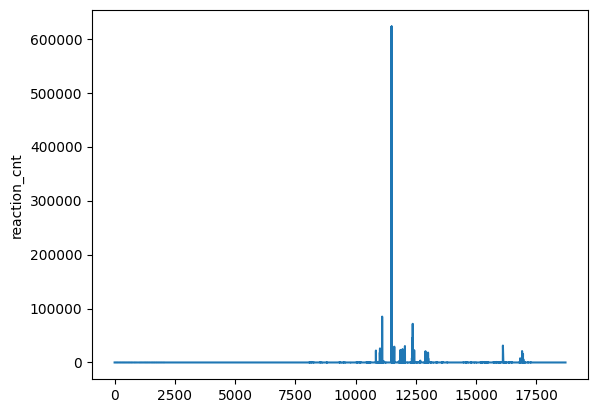

In [22]:
sns.lineplot(df['reaction_cnt'])
plt.show()

Судя по графику у нас есть много выбровов. Посмотрим колличество постов с более чем 100 реакциямию

In [23]:
df[df.reaction_cnt>100]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
8079,https://www.linkedin.com/in/tatberezka/recent-...,0,0,IT - recruiter (ищу системный аналитиков и инж...,0,0,0.0,0,0.0,"*не по рабочей теме*Друзья, очень нужна помощь...",241.0,9.0,25.0
8082,https://www.linkedin.com/in/tatberezka/recent-...,0,0,IT - recruiter (ищу системный аналитиков и инж...,0,0,0.0,0,0.0,#looking_for_a_job#job И снова здравствуйте!) ...,227.0,6.0,48.0
8089,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Хай, нетворк!Требуется помощь профессиональных...",316.0,0.0,40.0
8094,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Уважаемые коллеги! Просьба ко всем, кто в поры...",379.0,131.0,0.0
8103,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,Ох №2Пора подводить итоги этого спонтанного ма...,284.0,13.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17101,https://www.linkedin.com/in/alekseyyaroshenko,0,Aleksey Yaroshenko,"Data Scientist at VK, mail.ru antifraud ML team",VK,0,0.0,0,0.0,"Доехал диплом от MADE и МИСиС. Официально, не ...",175.0,22.0,0.0
17150,https://www.linkedin.com/in/michael-pochkaylov...,0,Michael Pochkaylov,Head of Analytics,Sberbank,0,0.0,0,0.0,Preparing for a Data Analytics Interview at Go...,521.0,52.0,29.0
17151,https://www.linkedin.com/in/michael-pochkaylov...,0,Michael Pochkaylov,Head of Analytics,Sberbank,0,0.0,0,0.0,A month ago I started a (fake) new job. I did ...,131.0,3.0,15.0
17206,https://www.linkedin.com/in/olegshokin,0,Oleg Shokin,Senior Golang Developer at OZON.ru,OZON.ru,0,0.0,0,0.0,"С удовольствием сообщаю, что я начинаю работу ...",121.0,17.0,0.0


Таких всего 326. Посмотрим более внимательно на посты с реакциями до 100 шт

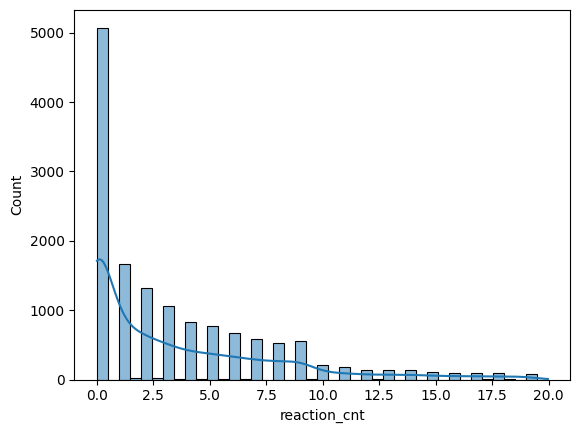

In [24]:
sns.histplot(df[df.reaction_cnt<20]['reaction_cnt'], kde=True)
plt.show()

Здесь график больше похож на равномерное распределение. Есть и провалы, конечно. Посмотрим сколько постов без реакций.

In [25]:
df.reaction_cnt.value_counts(dropna=False)

reaction_cnt
0.0        5074
1.0        1650
2.0        1298
3.0        1043
4.0         825
           ... 
574.0         1
30436.0       1
4884.0        1
408.0         1
635.0         1
Name: count, Length: 639, dtype: int64

Получается, что 5000 постов без реакций. Более 50%.

# comments_cnt - кол-во комментариев.

Посмотрим на распределение reaction_cnt.

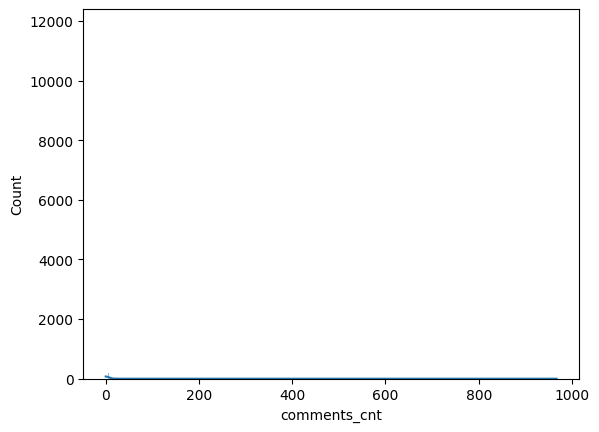

In [26]:
sns.histplot(df.comments_cnt, kde=True)
plt.show()

Тут также серьезные выбросы.

In [27]:
df[df.comments_cnt>20]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
8094,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Уважаемые коллеги! Просьба ко всем, кто в поры...",379.000,131.0,0.0
8105,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Коллеги, прошу репост.Одной из целей 2020 (все...",1.535,449.0,165.0
8153,https://www.linkedin.com/in/mikhailsolovyev/re...,0,0,"We build cloud services - IAAS, PAAS, SAAS",0,0,0.0,0,0.0,"Написал статью для Forbes о том, что изменилос...",74.000,36.0,1.0
8171,https://www.linkedin.com/in/%D0%BF%D0%BE%D0%BB...,0,0,IT Recruiter,0,0,0.0,0,0.0,"Google настолько силен, что скрывает от нас др...",1.523,53.0,215.0
8172,https://www.linkedin.com/in/%D0%BF%D0%BE%D0%BB...,0,0,IT Recruiter,0,0,0.0,0,0.0,🔵 Самая большая подборка для прокачки soft ski...,1.569,85.0,361.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17252,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,tech recruiter and developer #devlife,1.000,48.0,81.0
17253,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,#it #humor,0.000,92.0,42.0
17256,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,#mood #relax #work #life,8.000,302.0,68.0
17258,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,Quote of the day. #QOTD,6.000,87.0,554.0


Посто с комментариями больше 20 всего 337.

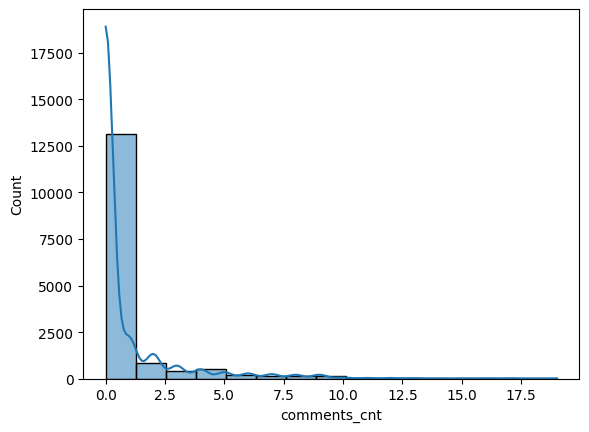

In [28]:
sns.histplot(df[df.comments_cnt<20]['comments_cnt'], kde=True)
plt.show()

В таком диапазоне мы видим четкий пик у 0. А далее снижение кол-ва комментариев до 10. Далее практически нет постов. Единичные сучаи.

In [29]:
df.comments_cnt.value_counts(dropna=False)

comments_cnt
0.0      11805
1.0       1336
2.0        822
3.0        434
4.0        312
         ...  
337.0        1
315.0        1
554.0        1
191.0        1
380.0        1
Name: count, Length: 255, dtype: int64

2/3 постов без комментариев.

# repost_cnt - кол-во репостов.

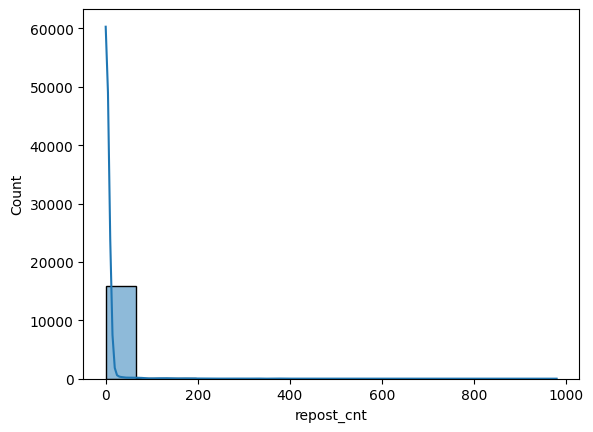

In [30]:
sns.histplot(df.repost_cnt, kde=True)
plt.show()

Тут также серьезные выбросы.

In [31]:
df[df.repost_cnt>20]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
8079,https://www.linkedin.com/in/tatberezka/recent-...,0,0,IT - recruiter (ищу системный аналитиков и инж...,0,0,0.0,0,0.0,"*не по рабочей теме*Друзья, очень нужна помощь...",241.000,9.0,25.0
8082,https://www.linkedin.com/in/tatberezka/recent-...,0,0,IT - recruiter (ищу системный аналитиков и инж...,0,0,0.0,0,0.0,#looking_for_a_job#job И снова здравствуйте!) ...,227.000,6.0,48.0
8089,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Хай, нетворк!Требуется помощь профессиональных...",316.000,0.0,40.0
8092,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Коллеги, прошу репост!Если вы, будучи граждани...",1.606,0.0,112.0
8105,https://www.linkedin.com/in/agratoth/recent-ac...,0,0,CTO/Co-founder,0,0,0.0,0,0.0,"Коллеги, прошу репост.Одной из целей 2020 (все...",1.535,449.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17256,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,#mood #relax #work #life,8.000,302.0,68.0
17257,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,"Ура, товарищи. Первый собес в 2023 году состоя...",3.000,0.0,73.0
17258,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,Quote of the day. #QOTD,6.000,87.0,554.0
17259,https://www.linkedin.com/in/ma-popovv,0,Matvey Popov,Software Engineer at Yandex,Yandex,0,0.0,0,0.0,How To Develop REST CRUD API Using Spring Boot...,635.000,0.0,33.0


Постов с репостами больше 20 всего 311.

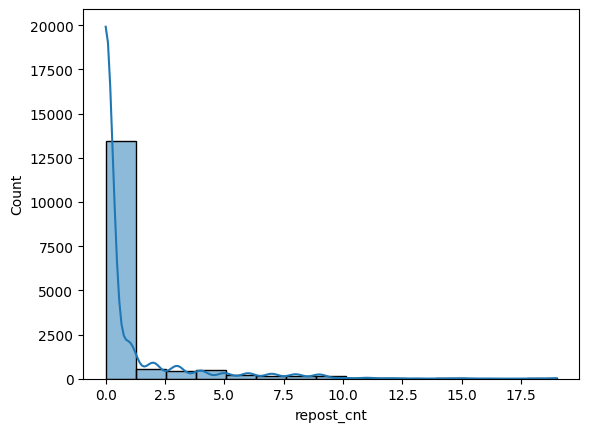

In [32]:
sns.histplot(df[df.repost_cnt<20]['repost_cnt'], kde=True)
plt.show()

В таком диапазоне мы видим четкий пик у 0. А далее снижение кол-ва репостов до 10. Далее практически нет постов. Единичные сучаи.

In [33]:
df.repost_cnt.value_counts(dropna=False)

repost_cnt
0.0      12224
1.0       1209
2.0        549
3.0        442
4.0        279
         ...  
121.0        1
91.0         1
278.0        1
189.0        1
214.0        1
Name: count, Length: 256, dtype: int64

2/3 постов без репостов.

Распределение репостов и комментариев очень похожи. Инетересно посмотреть, как они зависят друг от друга. Для оцнки зависимостей воспользуемся данными без выбросов.

In [34]:
df_part =df[(df['comments_cnt']<20) & (df['reaction_cnt']<100) & (df['reaction_cnt']<20)]


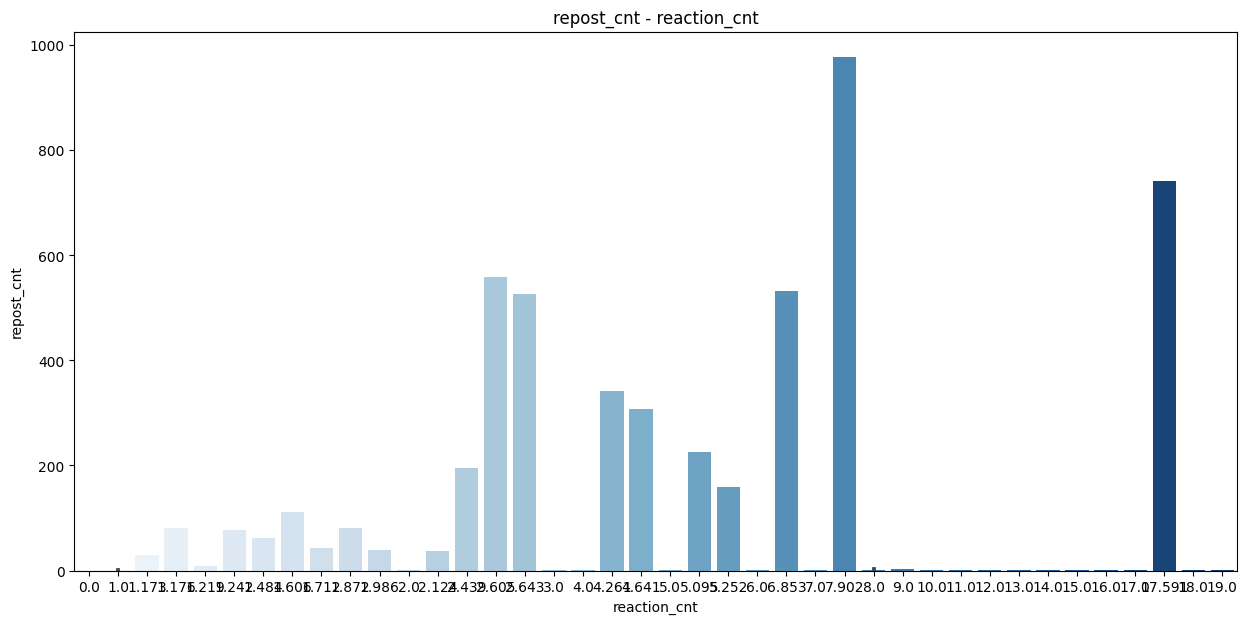

In [35]:
plt.figure(figsize=(15,7))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df_part, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

Все также логично, с увеличением кол-ва реакций на пост, увеличивается кол-во тех,к то репостит.

Посмотрим связано ли кол-во репостов с реакциями.

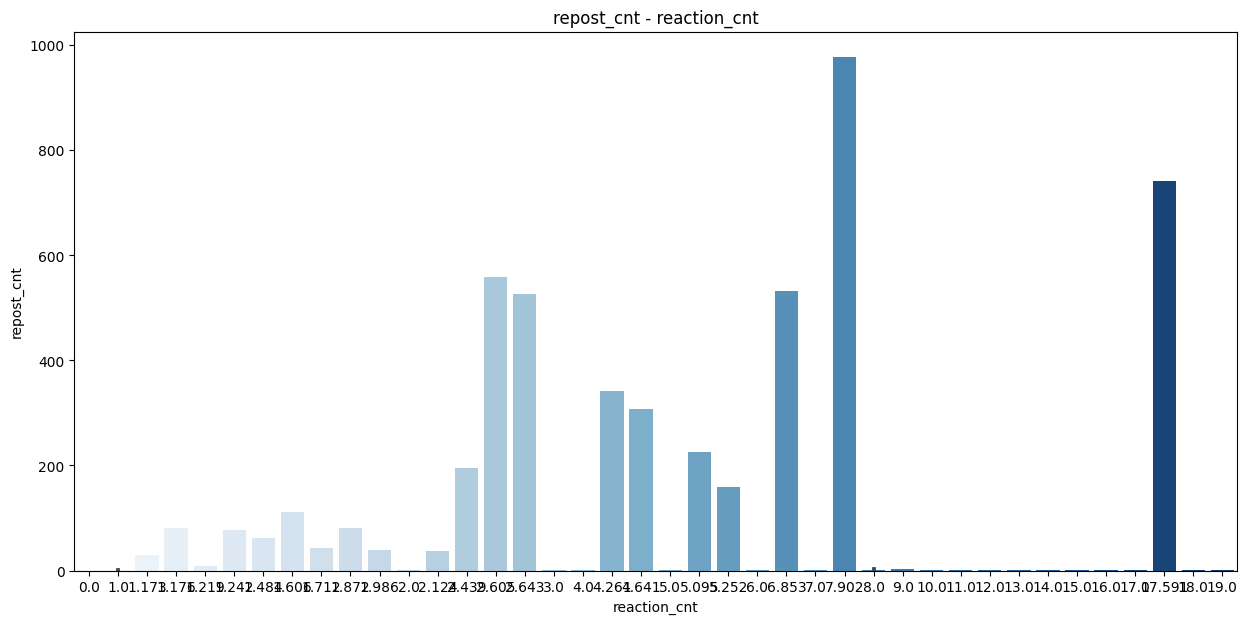

In [36]:
plt.figure(figsize=(15,7))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df_part, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

Проверим, есть ли в данных рекрутеры.

In [37]:
df[df['title'].str.contains('Recruit')==True]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
27,https://www.linkedin.com/in/ACoAAAqhWrQB8mmVQS...,lead frontend,Kristina Korobko,Lead IT Recruiter,DreamTeam,•\tkk@dream-team.tech•\tTelegram: @kkorobko•\t...,8.0,Россия,0.0,0,0.0,0.0,0.0
40,https://www.linkedin.com/in/ACoAABkz7KkBFOaZUx...,middle test engineer,Anastasia Usoltseva,Senior Technical Recruiter (Armenia/Serbia),Grid Dynamics,With nearly 5 years of experience in IT recrui...,9.0,"Белград, Сербия",0.0,0,0.0,0.0,0.0
639,https://www.linkedin.com/in/ACoAABkz7KkBFOaZUx...,lead frontend,Anastasia Usoltseva,Senior Technical Recruiter (Armenia/Serbia),Grid Dynamics,With nearly 5 years of experience in IT recrui...,9.0,"Белград, Сербия",0.0,0,0.0,0.0,0.0
668,https://www.linkedin.com/in/ACoAAAfSmP0BPGYrNv...,lead frontend,Lydia Saranina,Technical Talent Huntress at Anchous Drive Rec...,ADDFORCE Inc,9+ years of experience as a Full Cycle Technic...,13.0,Область залива Сан-Франциско,0.0,0,0.0,0.0,0.0
722,https://www.linkedin.com/in/ACoAAAqhWrQB8mmVQS...,lead frontend,Kristina Korobko,Lead IT Recruiter,DreamTeam,•\tkk@dream-team.tech•\tTelegram: @kkorobko•\t...,8.0,Россия,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18364,https://www.linkedin.com/in/ACoAAAEHeCMBgcmc0U...,0,Alla Afanasieva,HR Specialist / IT Recruiter,0,0,0.0,0,0.0,"'Просто хочу поделиться, красиво. Ногинск. Ог...",0.0,0.0,0.0
18365,https://www.linkedin.com/in/ACoAAAEHeCMBgcmc0U...,0,Alla Afanasieva,HR Specialist / IT Recruiter,0,0,0.0,0,0.0,'Вакансия #QA #Tester у нас тоже есть! Локаци...,0.0,0.0,0.0
18366,https://www.linkedin.com/in/ACoAAAEHeCMBgcmc0U...,0,Alla Afanasieva,HR Specialist / IT Recruiter,0,0,0.0,0,0.0,"'Dear all, let me introduce our Company page....",0.0,0.0,0.0
18367,https://www.linkedin.com/in/ACoAAAEHeCMBgcmc0U...,0,Alla Afanasieva,HR Specialist / IT Recruiter,0,0,0.0,0,0.0,"'Добрый день! Давно не заходила, рада всех ви...",0.0,0.0,0.0


Есть такие. Посмотрим сколько таких аккаунтов.

In [38]:
len(df[df['title'].str.contains('Recruiter')==True])

612

Почистим данные от рекрутеров.

In [39]:
df = df[df['title'].str.contains('Recruiter')==False]

In [40]:
df.shape

(15498, 13)

In [41]:
df.account_link.nunique()

1890

Посмотрим на должности наших специалистов.

In [42]:
df.title.unique()

array(['Senior Web Developer - IBS InfinitySoft',
       'LOOKING FOR "Senior/Lead Frontend (React) Developer" VACANCY',
       'Data Analyst at X5 Group', ...,
       'Lead iOS developer at Yandex Travel', 'Lead iOS-developer',
       'iOS Developer at Tinkoff Digital'], dtype=object)

In [43]:
mistakes=['Ищу срочно: Главного геолога (изыскания)! Локация -Москва либо Тольятти', '17000+ | Комплексная помощь в поиске работы | im-konsalting.ru  | mail@im-konsalting.ru | WhatsApp/Telegram: 79643223069',
            'Руководитель подразделений маркетинга и стратегического развития в крупных компаниях на B2C рынке | 11 000+','Строю крутые отделы продаж. Обучаю в формате «Реалити». Я - Владимир Якуба',
            'Специалист по найму персонала – V Kontakte LLC',]
df=df.query('title not in @mistakes')

Итого  наш предобработанный файл:

In [44]:
df.shape

(15476, 13)

Это 9277 строк.

In [45]:
df.account_link.nunique()

1885

1067  уникальных пользователей.

In [46]:
df

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0.0,0,0.0,0.0,0.0
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1.0,Я только что получил(а) значок за навык «JavaS...,1.0,0.0,0.0
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1.0,Hi everyone - I am looking for a new role and ...,0.0,0.0,0.0
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0.0,0,0.0,0.0,0.0
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,0,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9.0,Finding a job for trainees and juniors is a ch...,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18699,https://www.linkedin.com/in/sergey-cheliuskin-...,0,Sergey Cheliuskin-Galich,iOS Developer,0,0,0.0,0,1.0,Добрый день! На данный момент нахожусь в поиск...,0.0,0.0,0.0
18700,https://www.linkedin.com/in/nick-puchko/,0,Nikolai Puchko,Lead iOS developer at Yandex Travel,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0
18701,https://www.linkedin.com/in/nikita-susoev-40b7...,0,Nikita Susoev,Lead iOS-developer,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0
18702,https://www.linkedin.com/in/ivan-sergunin-2676...,0,Ivan Sergunin,iOS Developer at Sberbank,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0


## Подготовка текстов

Токенизацию и лемматизацию текстов.

In [47]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Складываем все посты в один список

In [48]:
df["post_text"]  = df["post_text"] .astype('str')

Посмотрим на кол-во символов в постах.

In [49]:
df["symbols"] = [len(x) for x in df['post_text']]

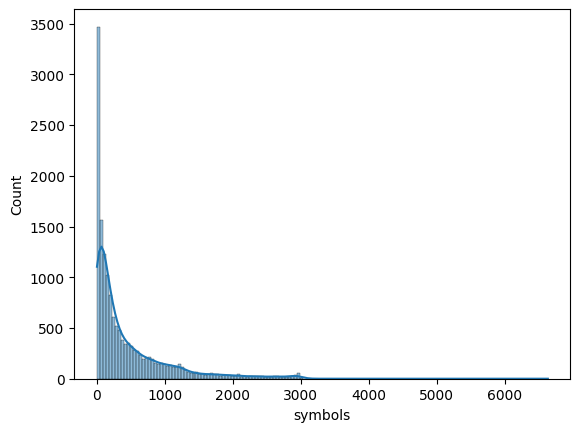

In [50]:
sns.histplot(df.symbols, kde=True)
plt.show()

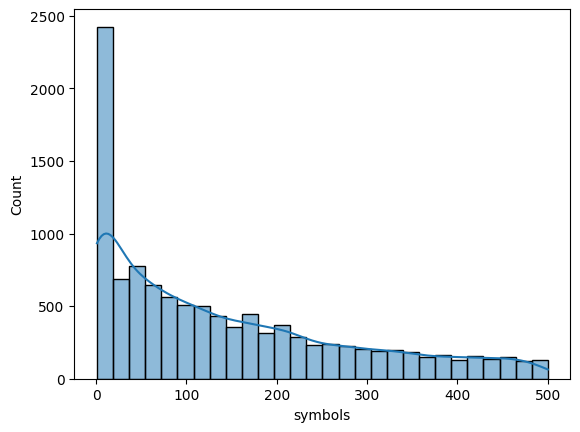

In [51]:
sns.histplot(df[df.symbols<=500].symbols, kde=True)
plt.show()

Посмотрим кол-во постов с текстом до 100 символов.

In [52]:
df[df.symbols<=50]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt,symbols
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0.0,0,0.0,0.0,0.0,1
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0.0,0,0.0,0.0,0.0,1
10,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,0,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9.0,0,4.0,0.0,0.0,1
11,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,0,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9.0,0,3.0,3.0,0.0,1
13,https://www.linkedin.com/in/andrew-sergeev-70b...,senior QA engineer,Andrew Sergeev,Senior QA Engineer - Deutsche Bank,Московский Государственный Институт Радиотехни...,- Test plan design - Test cases implementation...,12.0,Россия,0.0,0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18698,https://www.linkedin.com/in/alexey-artyushin/,0,Alexey Artyushin,Senior IOS Developer - Tinkoff,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0,10
18700,https://www.linkedin.com/in/nick-puchko/,0,Nikolai Puchko,Lead iOS developer at Yandex Travel,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0,10
18701,https://www.linkedin.com/in/nikita-susoev-40b7...,0,Nikita Susoev,Lead iOS-developer,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0,10
18702,https://www.linkedin.com/in/ivan-sergunin-2676...,0,Ivan Sergunin,iOS Developer at Sberbank,0,0,0.0,0,0.0,нет постов,0.0,0.0,0.0,10


865 строк. Посмотрим, что это за посты.

In [53]:
df[df.symbols<=50]['post_text'].unique()

array(['0', 'К-коварство)))', 'Всем бодрого утра среды!', ...,
       'https://lnkd.in/grs_CJv Alex Bush',
       "Time has come. I'm open to new opportunities.", ')))'],
      dtype=object)

Кажется, что от таких постов точно можно избавиться.

In [54]:
df =df[df.symbols>=50]

Посмотрим визуально наиболее распространенные слова в текстах.

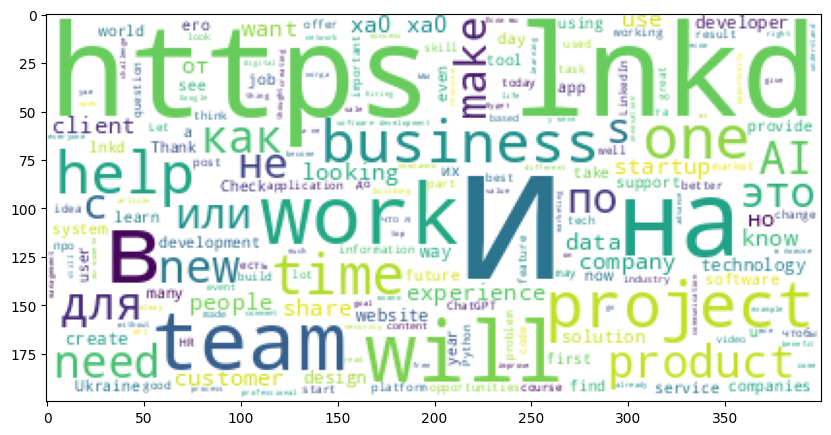

In [55]:
long_string = ','.join(list(df['post_text'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

plt.figure(figsize=(10,15))

wordcloud.generate(long_string)

plt.imshow(wordcloud)

In [56]:
texts = df["post_text"].tolist()

Выполняем лемматизацию текстов.

In [57]:
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

In [58]:
with open("lemmas.json", "w") as fid:
    json.dump({"lemmas": res}, fid)



Удалим знаки препинания, цифры и слова, содержащие цифры. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.



In [59]:
word_pattern = re.compile("^[а-яА-ЯёЁ]*$")

In [60]:
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [61]:
corpus = list(map(remove_symbols, res))

## Векторизация текстов

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [62]:
stop_words = stopwords.words('russian')
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

Т.е. TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [63]:
tfidf = TfidfVectorizer(stop_words=stop_words)

In [64]:
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['я только что значок за навык кто хотеть быть следующий пройти тест на проверка навык',
 '',
 '']

In [65]:
docs = list(filter(None, docs))

Проведем стемминг текстов.

In [66]:
from pymystem3 import Mystem
from tqdm import tqdm
m = Mystem()
stemmed = set()
voc_len = len(docs)
for i in tqdm(range(voc_len)):
    word = docs.pop()
    stemmed_word = m.lemmatize(word)[0]
    stemmed.add(stemmed_word)

stemmed = list(stemmed)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
100%|██████████| 4724/4724 [00:22<00:00, 211.94it/s]


In [67]:
x = tfidf.fit_transform(stemmed)

In [68]:
x.shape

(1104, 1023)

Теперь составим словарь

In [69]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 5.

In [70]:
n_topics = 6

In [71]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31,max_iter=20,n_jobs=6, learning_method='batch',verbose=1)

In [72]:
topics = lda.fit_transform(x)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


In [73]:
topics.shape

(1104, 6)

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 5 тем. В свойсте _components_ _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 5 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [74]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
небольшой, многие, модульный, плюс, консультация, изя, событие, джуна, автовоз, коммерческий, поставлять, январский, травня, помимо, поповненний, коротша, монетизация, вне, недвижимость, вчера

 
Тема 2 :
придерживаться, рыхтуй, задумываться, лайфхак, якщо, делиться, февраль, приходить, минуть, писать, кирилл, ак, лента, отъезжать, подякувать, недостача, кожный, подборочка, штош, позволять

 
Тема 3 :
случайно, согласный, сервис, представлять, доезжать, месяц, запуск, делегирование, предложение, приспичить, попугай, бесплатный, хваст, задавать, часть, мобильный, скороченний, моделированиемодель, сталкиваться, спроектировановсвоемстилеразработка

 
Тема 4 :
автоматизация, ровно, ваш, ошибка, момент, каждый, юридический, справочник, токсичний, тренд, изменение, результативный, вестисполь, розыгрыш, страшный, перемог, маркетинг, фамилия, истина, горячий

 
Тема 5 :
центр, платформить, активно, рассказывать, дополнять, новый, каково, андрей, поздравлять, приезжать, денис, игрок, п

По полученным ключевым словам можно составить представление о содержании той или иной темы. Хотя иногда сочетания слов довольно странные )  

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [75]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df.iloc[doc_id]["post_text"])
    print("\n")

Тема  0
Revolutionize Your Business Workflow with Amwork: The All-in-One PlatformMeet Amwork, the ultimate multitool platform designed to cater to all your business needs. With a powerful builder that enables you to create a unique workspace tailored to your company's requirements, Amwork offers an extensive range of modules, such as CRM, project management, HR, and more. By streamlining business processes and enhancing collaboration, Amwork ensures a seamless experience for employees and partners alike. Boasting a user-friendly setup with no coding required, Amwork is the go-to solution for companies seeking to optimize their workflow and boost productivity.The Issue:Drawing on six years of experience as a system integrator, I've observed that over 60% of small and medium-sized businesses grapple with the absence of a universal software to manage all their processes. Consequently, they resort to using multiple applications, which often leads to unreliable integrations and user dissati

# Улучшим модель. Будем использовать Gensim.

Проведем очистку текста.

In [76]:

data = df.post_text.values.tolist()

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

data = [re.sub('\s+', ' ', sent) for sent in data]

data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("^[а-яА-ЯёЁ]*$",' ', sent) for sent in data]
pprint(data[:1])

['Я только что получил(а) значок за навык «JavaScript». Кто хочет быть '
 'следующим? Пройдите тест на проверку навыков #LinkedInSkillAssessment.']


In [77]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['только', 'что', 'получил', 'значок', 'за', 'навык', 'javascript', 'кто', 'хочет', 'быть', 'следующим', 'проидите', 'тест', 'на', 'проверку', 'навыков']]


Задаем биграммы и триграммы для модели.

In [78]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [79]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['только', 'что_получил_значок', 'за_навык', 'javascript', 'кто_хочет_быть_следующим', 'проидите_тест_на', 'проверку_навыков']


Зададим функцию для удаления стоп слов, лемматизации и формирования би и триграмм.

In [80]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Удалим стоп слова.

In [81]:
stop_words = stopwords.words('russian')
data_words_nostops = remove_stopwords(data_words)

Формируем биграммы.

In [82]:
data_words_bigrams = make_bigrams(data_words_nostops)


Загрузим модель и проведем лемматизацию.


In [83]:
nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['получил_значок', 'хотеть', 'следующим_проидите', 'тест', 'проверку_навыков']]


Формируем словарь.

In [84]:
id2word = corpora.Dictionary(data_lemmatized)

Задаем корпус для обучения.

In [85]:
texts = data_lemmatized

In [86]:

corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


Построим модель.

In [87]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Посмотрим на темы, выделенные моделью.

In [88]:
lda_model.print_topics()

[(0,
  '0.048*"ресурс" + 0.045*"xa" + 0.024*"связать" + 0.017*"образование" + 0.017*"мобильный" + 0.016*"подходить" + 0.010*"саиты" + 0.009*"ролик" + 0.009*"обеспечение" + 0.008*"вернуться"'),
 (1,
  '0.019*"команда" + 0.016*"проект" + 0.013*"опыт" + 0.013*"бизнес" + 0.013*"работа" + 0.010*"вакансия" + 0.009*"разработка" + 0.009*"новый" + 0.008*"разработчик" + 0.008*"задача"'),
 (2,
  '0.022*"компания" + 0.012*"год" + 0.012*"очень" + 0.011*"работа" + 0.011*"человек" + 0.011*"вопрос" + 0.011*"хотеть" + 0.010*"работать" + 0.008*"время" + 0.008*"нужный"'),
 (3,
  '0.019*"полезный" + 0.017*"рассказать" + 0.016*"онлаин" + 0.014*"статья" + 0.013*"инженер" + 0.013*"директор" + 0.012*"исследование" + 0.011*"книга" + 0.010*"удовольствием_сообщаю" + 0.009*"пример"'),
 (4,
  '0.033*"ситуация" + 0.032*"город" + 0.022*"основный" + 0.022*"карьера" + 0.020*"бренд" + 0.020*"продолжать" + 0.018*"которыи" + 0.015*"рекомендовать" + 0.013*"оффер" + 0.013*"отличный"'),
 (5,
  '0.052*"решение" + 0.047*"разв

Cложность (Perplexity) модели и согласованность (Coherence) темы - меры для оценки того, насколько хорошо выполнено тематическое моделирование.

In [89]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.531549974378201

Coherence Score:  0.4649616248509755


In [90]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.269901 -0.294389       1        1  37.281627
1      0.300550  0.273241       2        1  33.225127
6     -0.103441  0.013761       3        1  10.375360
3     -0.092962 -0.005988       4        1   8.345519
5     -0.130105  0.017563       5        1   4.255287
0     -0.117762 -0.005177       6        1   3.988732
4     -0.126181  0.000989       7        1   2.528348, topic_info=              Term         Freq        Total Category  logprob  loglift
23102           xa   912.000000   912.000000  Default  30.0000  30.0000
261        решение   437.000000   437.000000  Default  29.0000  29.0000
9          команда  1248.000000  1248.000000  Default  28.0000  28.0000
267       компания  1724.000000  1724.000000  Default  27.0000  27.0000
920       развитие   398.000000   398.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
5372      прокачка    25.798658    26.448795   Topic7  -5.2708   3.6527
3082     частность    25.458625    26.118655   Topic7  -5.2841   3.6520
1536      полезныи    22.332363    22.922352   Topic7  -5.4151   3.6515
1992   обращаитесь    22.429084    23.025961   Topic7  -5.4108   3.6513
2510           фон    22.450119    23.056227   Topic7  -5.4098   3.6510

[274 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
23102      1  0.394447           xa
23102      2  0.061358           xa
23102      3  0.054784           xa
23102      4  0.089846           xa
23102      5  0.012053           xa
...      ...       ...          ...
1667       4  0.992508       читать
338        7  0.980794    экономика
274        6  0.954727  электронный
1022       3  0.993243         этои
241        5  0.991150  эффективный

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 7, 4, 6, 1, 5])

Опираясь на график логичнее предположить, что в текстах всего 3 темы. Обучим модель на этом условии.

In [91]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Посмотрим на темы, выделенные моделью.

In [92]:
lda_model.print_topics()

[(0,
  '0.010*"xa" + 0.007*"можете_предложить" + 0.007*"совет" + 0.006*"рекомендации_контактов" + 0.006*"заранее_благодарю" + 0.006*"признательный" + 0.006*"вашу_поддержку" + 0.003*"𝐭𝐡𝐞" + 0.003*"танцор" + 0.002*"микросхема"'),
 (1,
  '0.012*"компания" + 0.011*"команда" + 0.010*"работа" + 0.009*"проект" + 0.007*"бизнес" + 0.007*"опыт" + 0.005*"вакансия" + 0.005*"разработка" + 0.005*"год" + 0.005*"новый"'),
 (2,
  '0.008*"человек" + 0.007*"очень" + 0.006*"время" + 0.006*"вопрос" + 0.006*"год" + 0.005*"делать" + 0.005*"работа" + 0.005*"нужный" + 0.005*"хотеть" + 0.004*"знать"')]

Cложность (Perplexity) и согласованность (Coherence):

In [93]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.018228238252853

Coherence Score:  0.566508055693797


Мы уменьшили сложность и увеличили согласованность.

In [94]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.191155  0.145802       1        1  51.334900
2      0.067652 -0.200961       2        1  41.467663
0     -0.258806  0.055159       3        1   7.197437, topic_info=          Term         Freq        Total Category  logprob  loglift
9      команда  1090.000000  1090.000000  Default  30.0000  30.0000
23102       xa   734.000000   734.000000  Default  29.0000  29.0000
282     проект   927.000000   927.000000  Default  28.0000  28.0000
661     бизнес   730.000000   730.000000  Default  27.0000  27.0000
234      совет   262.000000   262.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
24       робот    16.378961    19.478114   Topic3  -6.7713   2.4582
16961    банан    18.557162    45.737090   Topic3  -6.6464   1.7294
24124   турнир    18.339811    46.573492   Topic3  -6.6582   1.6995
426       день    21.158513   338.483011   Topic3  -6.5152  -0.1410
32         час    18.967785   135.047573   Topic3  -6.6245   0.6686

[201 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
23102      1  0.359192         xa
23102      2  0.446269         xa
23102      3  0.194562         xa
1064       1  0.049819  актуально
1064       3  0.946553  актуально
...      ...       ...        ...
25673      3  0.967353     𝐩𝐞𝐨𝐩𝐥𝐞
25694      3  0.970320    𝐩𝐫𝐨𝐭𝐞𝐜𝐭
20609      3  0.996787      𝐫𝐢𝐠𝐡𝐭
1924       3  0.984538        𝐭𝐡𝐞
20568      3  0.964424         𝐭𝐨

[266 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

Опираясь на полученные данные можно предложить, что в текстах 3 темы:
1. Информация о компаниях, командах, новые проекты и появление вакансий в компании.
2. Это тема человека. Результаты его работы, собеседования и проч.
3. Личные сообщения, не всегда касающиеся работы. Тут также просят рекомендаций в поиске работы. Именно в этой группе и встречается тема менторства.